In [1658]:
import numpy as np
from numpy import genfromtxt, savetxt
from numpy import linalg as la
import copy
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 5]

In [1693]:
class EchoStateNetwork:
    def __init__(self,res_size=10,num_inputs=3,num_outputs=1,inp_scaling=0.5,sr=0.5,lr=0.01,alpha=0.000001):
        self.res_size = res_size
        self.num_nputs = num_inputs
        self.num_outputs = num_outputs
        self.inp_scaling = inp_scaling
        self.sr = sr
        self.lr = lr
        self.alpha = alpha
        self.act = lambda x: 1. / (1. + np.exp(-x))
        
        self.W_in = inp_scaling*np.random.randint(2, size=[res_size,num_inputs])
        self.W_in[self.W_in == 0] = -inp_scaling
        
        self.W_res = np.random.normal(loc=0.0,scale=1.0,size=[res_size,res_size])
        converged = False
        while not converged:
            current_sr = max(np.abs(la.eigvals(self.W_res)))
            self.W_res *= sr/current_sr
            if (-0.01 < (current_sr-sr)) and (0.01 > (current_sr-sr)):
                converged = True
        #self.W_res = np.zeros([res_size,res_size]) # REMOVE
        self.b_res = np.random.normal(loc=0.0,scale=0.5,size=res_size)
        
        self.W_out = np.random.normal(loc=0.0,scale=1.0,size=[num_outputs,res_size])
        self.b_out = np.random.normal(loc=0.0,scale=1.0,size=num_outputs)
        
        self.inputs = np.zeros(num_inputs)
        self.res_states = np.zeros(res_size)
        self.res_outputs = np.zeros(res_size)
        self.outputs = np.zeros(num_outputs)
                
    def forward(self,inputs):
        self.inputs = inputs
        self.res_states = np.dot(self.W_in,self.inputs) + np.dot(self.W_res,self.res_outputs) + self.b_res
        self.res_outputs = self.act(self.res_states)
        self.outputs = np.dot(self.W_out,self.res_outputs) + self.b_out
        
    def train(self,targets):
        for i in range(self.num_outputs):
            err = self.outputs[i] - targets[i]
            self.b_out[i] -= 2*self.lr*(err + self.alpha*np.abs(self.b_out[i]))
            for j in range(self.res_size):
                self.W_out[i][j] -= 2*self.lr*(err*self.res_outputs[j] + self.alpha*np.abs(self.W_out[i][j]))

In [2110]:
esn_template = EchoStateNetwork(res_size=30,num_inputs=2,num_outputs=1,inp_scaling=2.5,sr=5.,lr=0.001)

In [2167]:
t_C = 0.1
t_L = 0.003
dt = 0.0
N = 2
f_L = [-1,1]

centers_filename = "Data/centers_"+str(t_C)+"_"+str(t_L)+"_"+str(dt)+"_"+str(N)+".csv"
counts_filename = "Data/counts_"+str(t_C)+"_"+str(t_L)+"_"+str(dt)+"_"+str(N)+".csv"

In [2168]:
centers = genfromtxt(centers_filename, delimiter=',')
counts = genfromtxt(counts_filename, delimiter=',')
max_count = np.amax(counts)
counts = counts/max_count
split = 0.7 # 70% training, 30% testing
total_cycles = len(centers)
split_idx = int(split*total_cycles)
train_centers = centers[0:split_idx]
train_counts = counts[0:split_idx]
test_centers = centers[split_idx:]
test_counts = counts[split_idx:]
esn = copy.deepcopy(esn_template)

In [2169]:
test_iterations = len(test_centers)
#print(test_iterations)
warm_up = 5

def evaluate():
    TSE = 0.
    outputs = np.zeros(test_iterations-warm_up)
    for i in range(warm_up):
        esn.forward(test_counts[i])
    for i in range(test_iterations-warm_up):
        esn.forward(test_counts[i+warm_up])
        outputs[i] = esn.outputs[0]
        TSE += (outputs[i] - test_centers[i+warm_up])**2
    RMSE = np.sqrt(TSE/(test_iterations-warm_up))
    print(round(RMSE,4))

In [2170]:
train_iterations = len(train_centers)
#train_iterations = 349
epochs = 10
warm_up = 5
#print(train_iterations)
#print(" ")

# Training loop
for _ in range(epochs):
    for i in range(warm_up):
        esn.forward(train_counts[i])
    for i in range(train_iterations-warm_up):
        esn.forward(train_counts[i+warm_up])
        esn.train(np.array([train_centers[i+warm_up]]))
    evaluate()

0.3295
0.256
0.2202
0.1987
0.1835
0.172
0.1628
0.1552
0.1488
0.1434


## Plotting Prediction

In [1481]:
all_centers = genfromtxt('Data/AllNoiseSimulatedData.csv', delimiter=',')
timestep = 0.00005
total_time = 500
print(len(all_centers))
print(np.std(all_centers))

10000000
0.2935554226645889


In [1482]:
t_C = 0.1
t_L = 0.01
dt = 0.02
N = 3
f_L = [-1,0,1]

num_cycles = int(total_time/t_C) - 1
steps_per_cycle = int(t_C/timestep)
steps_per_measurement = int(t_L/timestep)
steps_per_prediction = int(dt/timestep)

centers = np.zeros(num_cycles)
counts = np.zeros([num_cycles,N])

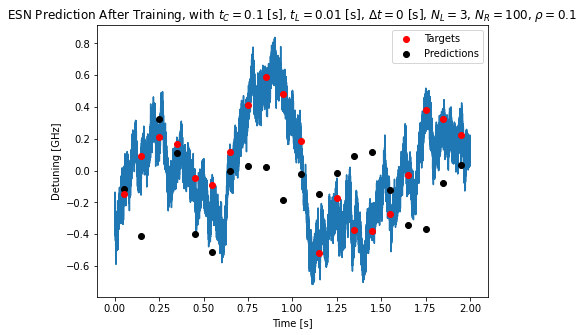

In [1483]:
n = 40000
times = np.arange(n)*timestep
all_idx = split_idx*steps_per_cycle
ctrs = all_centers[all_idx+warm_up*steps_per_cycle:all_idx+n+warm_up*steps_per_cycle]
num_c = int(n*timestep/t_C)
predict_times = np.arange(num_c)*t_C + 3*t_L + dt
y = outputs[0:num_c]
t = test_centers[warm_up:warm_up+num_c]

plt.xlabel("Time [s]")
plt.ylabel("Detuning [GHz]")
plt.title("ESN Prediction After Training, with $t_C=0.1$ [s], $t_L=0.01$ [s], $\Delta t=0$ [s], $N_L=3$, $N_R=100$, $\\rho=0.1$")
plt.rcParams['figure.figsize'] = [12,8]

plt.scatter(predict_times,t,color="red",zorder=3,label="Targets")
plt.scatter(predict_times,y,color="black",zorder=2,label="Predictions")
plt.plot(times,ctrs,zorder=1)
plt.legend()